In [1]:
import pandas as pd
import numpy as np
import os
import sys
import dotenv
from dotenv import load_dotenv

In [23]:
import sys
# Go one level up to the project root
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from common.PortConnect import Port_Connect
from common.Portfolio import Portfolio_Stats

# Use the portfolio connector to retrieve prices

In [7]:
fmp_key = os.getenv("API_KEY")

In [16]:
port = Port_Connect(api_key=fmp_key)
portfolio = Portfolio_Stats()

# Asset-Only Asset Allocations and Mean–Variance Optimization

## Calculate the investor's utility function for the asset mix

This is a formula that calculates the expected return for the investor, as a function of the expected return and an inverse relationship of the investor's risk aversion and variance return

Lets use the S&P 500 for this calculation

In [10]:
spy = port.get_closing_prices('SPY')
spy.sample(3)

/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:62: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.set_index = pd.to_datetime(df.index, infer_datetime_format=True)
/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:250: UserWarning: 

symbol,SPY
date,
2003-11-10,105.18
2002-02-11,111.44
2022-06-08,411.22


Calculate the percentage change of the daily closing prices

In [11]:
spy['Change']  = spy['SPY'].pct_change()
spy.tail(3)

symbol,SPY,Change
date,,
2025-03-20,565.49,-0.002892
2025-03-21,563.98,-0.002670
2025-03-24,574.08,0.017908


What is the range of the data?

In [13]:
print("The first date is ",spy.index[0])
print("The last date is ",spy.index[-1])

The first date is  1993-01-29 00:00:00
The last date is  2025-03-24 00:00:00


Now, let's calculate the mean return and variance of the whole series

In [30]:
mean_return = portfolio.annualize_rets(spy['Change'],252)
mean_vol = spy['Change'].var() * 252

print('Mean return is ',np.round(mean_return,5) * 100)
print('Mean Variance is ',np.round(mean_vol,5) * 100)

Mean return is  8.331
Mean Variance is  3.465


Lets calculate the investors utility of the SPY

$$
U_m = E(R_m) - 0.5 \lambda \sigma_m^2
$$

$U_m$ = the investor’s utility for asset mix (allocation) m

$E(R_m)$  = the return for asset mix m

$ \lambda $ = the investor’s risk aversion coefficient

$ \sigma_m^2 $ = the expected variance of return for asset mix m

so lets assume that the risk aversion coefficient for an investor is 2 (Risk tolerant investor)

In [34]:
ret = mean_return
vol = mean_vol
risk_coefficient = 2

investor_utility = ret - 0.5*risk_coefficient*vol
print('The investors utility is ',np.round(investor_utility,4) * 100)

The investors utility is  4.87


so, what does it mean that the investor's utility is 4.87%? 

The 4.87% can be interpreted as the certainty equivalent return—the guaranteed return the investor would consider equally desirable as the risky investment. Despite the potential for higher returns with risk, the risk penalty “lowers” the effective return to 4.87% given the investor’s risk preferences.



## Use Monte Carlo Simulation in order to analyze a portfolio for retirement

The client has 1M USD as his initial portfolio, wants to withdraw 5OK USD per year and expects to live 25 years more. He wants to live his children the same 1M USD in real terms (inflation of 2.6% annually)

Assuming a return of 8.5% and a volatility of 18%, what is the probability of achieving the desired goal?

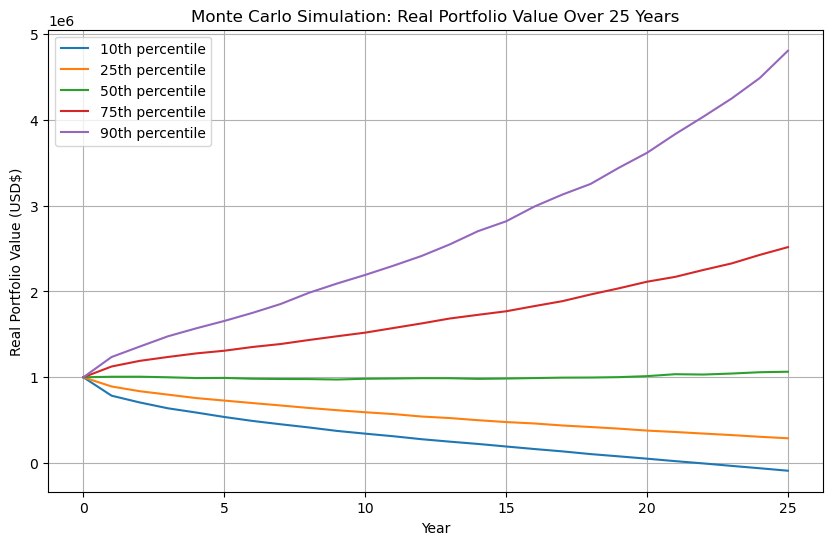

Median Real Portfolio Value at end of 25 years: USD$ 1064502.72


In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
initial_portfolio = 1_000_000     # Initial portfolio value in USD$
withdrawal = 50_000               # Annual withdrawal in USD$
years = 25                      # Retirement period (years)
n_simulations = 10000           # Number of Monte Carlo simulation runs

# Capital market expectations for the portfolio (nominal values)
nominal_return_mean = 0.085     # 7.5% expected nominal return per year
nominal_return_std = 0.18       # 11% standard deviation of nominal returns
inflation = 0.026               # 2.6% annual inflation

# Create an array to hold the portfolio values for each simulation over time.
# We include year 0 (the starting portfolio) and then one value per year.
portfolio_sim = np.zeros((n_simulations, years + 1))
portfolio_sim[:, 0] = initial_portfolio

# Run the Monte Carlo simulation for each simulation path
for sim in range(n_simulations):
    portfolio = initial_portfolio
    for year in range(1, years + 1):
        # Draw a random nominal return for the year from a normal distribution.
        r = np.random.normal(nominal_return_mean, nominal_return_std)
        # Update the portfolio: grow by the nominal return, then withdraw the fixed amount.
        portfolio = portfolio * (1 + r) - withdrawal
        portfolio_sim[sim, year] = portfolio

# Discount nominal portfolio values to real terms by adjusting for inflation.
# Create an array of discount factors: (1 + inflation) ** year
years_array = np.arange(years + 1)
discount_factors = (1 + inflation) ** years_array

# Divide each year's nominal value by the corresponding discount factor.
portfolio_sim_real = portfolio_sim / discount_factors[np.newaxis, :]

# Compute selected percentiles (10th, 25th, 50th, 75th, and 90th) across all simulations for each year.
percentiles = [10, 25, 50, 75, 90]
portfolio_percentiles = np.percentile(portfolio_sim_real, percentiles, axis=0)

# Plot the percentile paths over time.
plt.figure(figsize=(10, 6))
for i, perc in enumerate(percentiles):
    plt.plot(years_array, portfolio_percentiles[i, :], label=f"{perc}th percentile")
plt.xlabel("Year")
plt.ylabel("Real Portfolio Value (USD$)")
plt.title("Monte Carlo Simulation: Real Portfolio Value Over 25 Years")
plt.legend()
plt.grid(True)
plt.show()

# Print the median (50th percentile) real portfolio value at the end of 25 years.
median_bequest = np.median(portfolio_sim_real[:, -1])
print("Median Real Portfolio Value at end of 25 years: USD$", round(median_bequest, 2))


# Create Portfolio

In [134]:
prices = port.get_closing_prices(['MSFT','AAPL','KO','AMZN','O','AGNC','NVDA','FB'])
prices = prices[prices.index > '2000-01-01']
prices.sample(2)

/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:62: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.set_index = pd.to_datetime(df.index, infer_datetime_format=True)
/Users/franciscoruiz/Desktop/APPLIED_FINANCE_ANALYTICS/APPLIED_FINANCE_ANALYTICS/common/PortConnect.py:56: UserWarning: T

symbol,AAPL,AGNC,AMZN,FB,KO,MSFT,NVDA,O
date,,,,,,,,
2016-06-10,24.71,18.89,35.90,116.62,45.99,51.48,1.1600,62.27
2011-09-26,14.40,27.57,11.49,NaN,34.38,25.44,0.3455,32.75


In [135]:
rets = prices.pct_change()
cov_matrix = rets.cov() * 252
cov_matrix

/var/folders/01/l5vdw9pj3n7b0sg_9lmyyzbh0000gn/T/ipykernel_2504/3249739102.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()


symbol,AAPL,AGNC,AMZN,FB,KO,MSFT,NVDA,O
symbol,,,,,,,,
AAPL,0.149758,0.025622,0.070478,0.036089,0.018376,0.055954,0.096179,0.030306
AGNC,0.025622,0.074883,0.025322,0.012450,0.016389,0.023271,0.035041,0.040621
AMZN,0.070478,0.025322,0.242389,0.044673,0.015699,0.065795,0.104444,0.033551
FB,0.036089,0.012450,0.044673,0.116363,0.010675,0.034770,0.052346,0.017197
KO,0.018376,0.016389,0.015699,0.010675,0.042061,0.020108,0.015944,0.021101
MSFT,0.055954,0.023271,0.065795,0.034770,0.020108,0.091321,0.086776,0.030700
NVDA,0.096179,0.035041,0.104444,0.052346,0.015944,0.086776,0.353803,0.039977
O,0.030306,0.040621,0.033551,0.017197,0.021101,0.030700,0.039977,0.086220


In [136]:
port_stats = Portfolio_Stats()
port_stats.gmv(cov_matrix)

array([0.02568969, 0.19038503, 0.00815447, 0.14518898, 0.5077801 ,
       0.06167871, 0.        , 0.06112301])

In [137]:
rets

symbol,AAPL,AGNC,AMZN,FB,KO,MSFT,NVDA,O
date,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.084307,NaN,-0.082774,NaN,-0.008868,-0.033802,-0.026702,-0.011940
2000-01-05,0.014631,NaN,-0.148780,NaN,0.018969,0.010655,-0.032922,-0.006042
2000-01-06,-0.086542,NaN,-0.060172,NaN,0.001054,-0.033562,-0.065248,0.012158
2000-01-07,0.047370,NaN,0.060976,NaN,0.065965,0.013091,0.016692,0.018018
...,...,...,...,...,...,...,...,...
2025-03-19,0.011989,-0.002887,0.014106,0.0,-0.001441,0.011212,0.018106,-0.009129
2025-03-20,-0.005296,-0.006757,-0.003017,0.0,0.006207,-0.002527,0.008594,0.000354
2025-03-21,0.019477,-0.011662,0.006463,0.0,-0.014919,0.011426,-0.007002,-0.011690


In [138]:
port_rets = port_stats.annualize_rets(rets,252)
port_rets

symbol
AAPL    0.239748
AGNC   -0.026148
AMZN    0.164250
FB      0.067206
KO      0.036078
MSFT    0.078982
NVDA    0.326859
O       0.070338
dtype: float64

In [139]:
rets.cov() * 252

symbol,AAPL,AGNC,AMZN,FB,KO,MSFT,NVDA,O
symbol,,,,,,,,
AAPL,0.149758,0.025622,0.070478,0.036089,0.018376,0.055954,0.096179,0.030306
AGNC,0.025622,0.074883,0.025322,0.012450,0.016389,0.023271,0.035041,0.040621
AMZN,0.070478,0.025322,0.242389,0.044673,0.015699,0.065795,0.104444,0.033551
FB,0.036089,0.012450,0.044673,0.116363,0.010675,0.034770,0.052346,0.017197
KO,0.018376,0.016389,0.015699,0.010675,0.042061,0.020108,0.015944,0.021101
MSFT,0.055954,0.023271,0.065795,0.034770,0.020108,0.091321,0.086776,0.030700
NVDA,0.096179,0.035041,0.104444,0.052346,0.015944,0.086776,0.353803,0.039977
O,0.030306,0.040621,0.033551,0.017197,0.021101,0.030700,0.039977,0.086220


In [140]:
### Minimum covariance matrix
returns = port_stats.annualize_rets(rets,252)
minimum_variance_weights = port_stats.gmv(cov_matrix)
print(minimum_variance_weights)
portfolio_return = port_stats.portfolio_return(minimum_variance_weights,returns)
portfolio_vol = port_stats.portfolio_vol(minimum_variance_weights,cov_matrix)
print(portfolio_return)
print(portfolio_vol)

[0.02568969 0.19038503 0.00815447 0.14518898 0.5077801  0.06167871
 0.         0.06112301]
0.039768094111221515
0.17077420711200042


In [141]:
### Maximize Sharp Ratio
returns = port_stats.annualize_rets(rets,252)
maximum_sharpe_weights = port_stats.msr(0.03,returns,cov_matrix)
print(np.round(maximum_sharpe_weights,5))
portfolio_return = port_stats.portfolio_return(maximum_sharpe_weights,returns)
portfolio_vol = port_stats.portfolio_vol(maximum_sharpe_weights,cov_matrix)
print(portfolio_return)
print(portfolio_vol)

[0.64738 0.      0.00762 0.      0.      0.      0.34501 0.     ]
0.2692270060414379
0.38613077254395495


<Axes: xlabel='Volatility'>

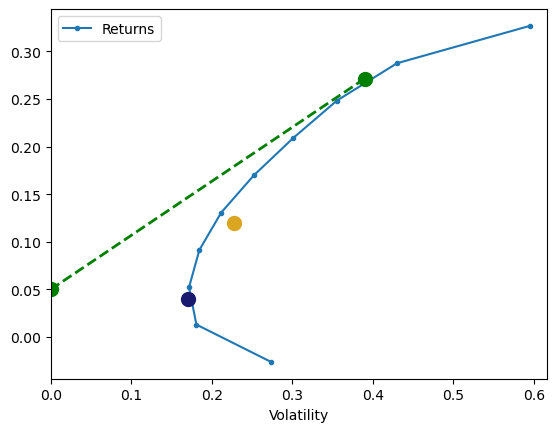

In [144]:
port_stats.plot_ef(10,returns,cov_matrix,show_ew=True, show_gmv=True,show_cml=True,riskfree_rate=0.05,legend=True)

# Black-Litterman Model
### Use the BL Model to better forecast asset returns and asset allocations